In [1]:
import numpy as np
import pickle
import math
from scipy.stats import sem
import matplotlib.pyplot as plt
import pandas as pd
import time
import pprint
import seaborn as sns
import statsmodels.formula.api as smf
import analysis_utils as au
import CMR_IA as cmr
from matplotlib.lines import Line2D
from scipy.stats import norm
# from sklearn.linear_model import LinearRegression
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 16
SAVE_FIG = False

In [2]:
with open("simu1_data/simu1_design.pkl", 'rb') as inp:
    df = pickle.load(inp)
# df = df.loc[df.session < 100]
df

,subject_ID,position,item,itemno,category_label,lag,old,session,study_itemno1,study_itemno2,test_itemno1,test_itemno2
0,58,0,UNDERWEAR,282,Clothing,0,False,0,282,-1,282,-1
1,58,1,JEANS,139,Clothing,0,False,0,139,-1,139,-1
2,58,2,JACKET,138,Clothing,0,False,0,138,-1,138,-1
3,58,3,TABLET,263,Electronics,0,False,0,263,-1,263,-1
4,58,4,COMPUTER,62,Electronics,0,False,0,62,-1,62,-1
...,...,...,...,...,...,...,...,...,...,...,...,...
579995,337,575,LAKE,148,Landscapes,0,False,999,148,-1,148,-1
579996,337,576,PIE,201,Desserts,78,True,999,201,-1,201,-1
579997,337,577,LOBSTER,160,OceanAnimals,90,True,999,160,-1,160,-1
579998,337,578,MAPLE,161,Trees,118,True,999,161,-1,161,-1


### Run CMR-IA

In [3]:
s_mat = np.load('simu1_data/simu1_300_smat.npy')

In [4]:
params = cmr.make_default_params()
params.update(
    beta_enc = 0.05,
    beta_rec = 0,
    beta_cue = 0,
    beta_rec_post = 0.01,
    gamma_fc = 0.1,
    s_fc = 0.096,
    c_thresh_itm = 0.544,
    use_new_context = True,
)
params

{'beta_enc': 0.05,
 'beta_rec': 0,
 'beta_cue': 0,
 'beta_rec_post': 0.01,
 'beta_distract': None,
 'phi_s': 2,
 'phi_d': 0.5,
 's_cf': 0,
 's_fc': 0.096,
 'kappa': 0.5,
 'eta': 0.5,
 'omega': 5,
 'alpha': 1,
 'c_thresh': 0.5,
 'c_thresh_itm': 0.544,
 'c_thresh_ass': 0.5,
 'd_ass': 1,
 'lamb': 0.5,
 'rec_time_limit': 60000.0,
 'dt': 10,
 'nitems_in_accumulator': 50,
 'max_recalls': 50,
 'learn_while_retrieving': False,
 'a': 2800,
 'b': 20,
 'm': 0,
 'n': 1,
 'c1': 0,
 'thresh_sigma': 0,
 'No_recall': None,
 'var_enc': 1,
 'bad_enc_ratio': 1,
 'gamma_fc': 0.1,
 'gamma_cf': 0.5,
 'use_new_context': True}

In [23]:
df_simu = cmr.run_conti_recog_multi_sess(params,df,s_mat,mode='Continuous')

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [09:56<00:00,  1.68it/s]

CMR Time: 596.8956980705261


In [24]:
df_simu = df_simu.merge(df,on=['session','position','study_itemno1','study_itemno2','test_itemno1','test_itemno2'])
df_simu

,session,position,study_itemno1,study_itemno2,test_itemno1,test_itemno2,s_resp,s_rt,csim,subject_ID,item,itemno,category_label,lag,old
0,0,0,282,-1,282,-1,0.0,0.052727,0.000000,58,UNDERWEAR,282,Clothing,0,False
1,0,1,139,-1,139,-1,0.0,0.071556,0.015268,58,JEANS,139,Clothing,0,False
2,0,2,138,-1,138,-1,0.0,0.098567,0.031280,58,JACKET,138,Clothing,0,False
3,0,3,263,-1,263,-1,0.0,0.111749,0.037556,58,TABLET,263,Electronics,0,False
4,0,4,62,-1,62,-1,0.0,0.160584,0.055684,58,COMPUTER,62,Electronics,0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
579995,999,575,148,-1,148,-1,0.0,1571.542480,0.515122,337,LAKE,148,Landscapes,0,False
579996,999,576,201,-1,201,-1,1.0,1194.728638,0.586585,337,PIE,201,Desserts,78,True
579997,999,577,160,-1,160,-1,1.0,848.243896,0.603710,337,LOBSTER,160,OceanAnimals,90,True
579998,999,578,161,-1,161,-1,1.0,1166.205566,0.587793,337,MAPLE,161,Trees,118,True


In [ ]:
df_simu.to_pickle("simu1_data/simu1_result.pkl")

### Preprocesssing

In [3]:
with open("simu1_data/simu1_result.pkl", 'rb') as inp:
    df_simu = pickle.load(inp)
df_simu = df_simu.loc[df_simu.session < 500]

In [4]:
# calculate the rolling category length
rolling_window = 9
category_label_dummies = df_simu['category_label'].str.get_dummies()
category_label_dummies.columns = ['cl_' + col for col in category_label_dummies.columns]
category_label_dummies_events = pd.concat([df_simu, category_label_dummies], axis=1) # record the occurrence of every cat label
cl_rolling_sum = category_label_dummies_events.groupby('session').rolling(rolling_window, min_periods=1, on='position')[category_label_dummies.columns].sum().reset_index()
df_rollcat = df_simu.merge(cl_rolling_sum, on=['session', 'position'])
df_simu['roll_cat_label_length'] = df_rollcat.apply(lambda x: x['cl_' + x['category_label']], axis = 1) # how many cat within 10 window
df_simu['roll_cat_label_length'] = df_simu['roll_cat_label_length'] - 1 # how many cat in previous 9 window. not include self

# add rolling category length level
# option = "0-1-2+"
option = "0+1-2+"
# option = "0-1+"
if option == "0-1-2+":
    # option 0: 0, 1, >=2
    df_simu['roll_cat_len_level']= pd.cut(x=df_simu.roll_cat_label_length, 
                                    bins=[0, 1, 2, np.inf], right=False, include_lowest = True,
                                    labels=['0', '1', '>=2']).astype('str')
elif option == "0+1-2+":
    # option 1: 0-1, >=2
    df_simu['roll_cat_len_level']= pd.cut(x=df_simu.roll_cat_label_length, 
                                    bins=[0, 2, np.inf], right=False, include_lowest = True,
                                    labels=['0-1', '>=2']).astype('str')
elif option == "0-1+":
    # option 2: 0, >=1
    df_simu['roll_cat_len_level']= pd.cut(x=df_simu.roll_cat_label_length, 
                                    bins=[0, 1, np.inf], right=False, include_lowest = True,
                                    labels=['0', '>=1']).astype('str')
df_simu

,session,position,study_itemno1,study_itemno2,test_itemno1,test_itemno2,s_resp,s_rt,csim,subject_ID,item,itemno,category_label,lag,old,roll_cat_label_length,roll_cat_len_level
0,0,0,282,-1,282,-1,0.0,0.052727,0.000000,58,UNDERWEAR,282,Clothing,0,False,0.0,0-1
1,0,1,139,-1,139,-1,0.0,0.071556,0.015268,58,JEANS,139,Clothing,0,False,1.0,0-1
2,0,2,138,-1,138,-1,0.0,0.098567,0.031280,58,JACKET,138,Clothing,0,False,2.0,>=2
3,0,3,263,-1,263,-1,0.0,0.111749,0.037556,58,TABLET,263,Electronics,0,False,0.0,0-1
4,0,4,62,-1,62,-1,0.0,0.160584,0.055684,58,COMPUTER,62,Electronics,0,False,1.0,0-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
289995,499,575,11,-1,11,-1,0.0,490.138794,0.456866,280,BASKETBALL,11,Toys,0,False,1.0,0-1
289996,499,576,210,-1,210,-1,0.0,511.606781,0.459009,280,PRINTER,210,Electronics,0,False,1.0,0-1
289997,499,577,265,-1,265,-1,1.0,1246.781006,0.584453,280,TEA,265,Beverages,19,True,1.0,0-1
289998,499,578,55,-1,55,-1,0.0,1772.001465,0.521125,280,CIDER,55,Beverages,38,True,2.0,>=2


In [5]:
# add log and log lag bin
df_simu['log_lag'] = np.log(df_simu['lag'])
df_simu['log_lag_bin'] = pd.cut(df_simu['log_lag'], np.arange(df_simu['log_lag'].max()+1), labels=False, right=False)
df_simu

/home1/beigejin/.conda/envs/CMR_IA/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,session,position,study_itemno1,study_itemno2,test_itemno1,test_itemno2,s_resp,s_rt,csim,subject_ID,item,itemno,category_label,lag,old,roll_cat_label_length,roll_cat_len_level,log_lag,log_lag_bin
0,0,0,282,-1,282,-1,0.0,0.052727,0.000000,58,UNDERWEAR,282,Clothing,0,False,0.0,0-1,-inf,NaN
1,0,1,139,-1,139,-1,0.0,0.071556,0.015268,58,JEANS,139,Clothing,0,False,1.0,0-1,-inf,NaN
2,0,2,138,-1,138,-1,0.0,0.098567,0.031280,58,JACKET,138,Clothing,0,False,2.0,>=2,-inf,NaN
3,0,3,263,-1,263,-1,0.0,0.111749,0.037556,58,TABLET,263,Electronics,0,False,0.0,0-1,-inf,NaN
4,0,4,62,-1,62,-1,0.0,0.160584,0.055684,58,COMPUTER,62,Electronics,0,False,1.0,0-1,-inf,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
289995,499,575,11,-1,11,-1,0.0,490.138794,0.456866,280,BASKETBALL,11,Toys,0,False,1.0,0-1,-inf,NaN
289996,499,576,210,-1,210,-1,0.0,511.606781,0.459009,280,PRINTER,210,Electronics,0,False,1.0,0-1,-inf,NaN
289997,499,577,265,-1,265,-1,1.0,1246.781006,0.584453,280,TEA,265,Beverages,19,True,1.0,0-1,2.944439,2.0
289998,499,578,55,-1,55,-1,0.0,1772.001465,0.521125,280,CIDER,55,Beverages,38,True,2.0,>=2,3.637586,3.0


In [6]:
# construct local FAR
# for i in range(1, len(df_simu)):
#     if df_simu.loc[i, 'old'] == False and df_simu.loc[i-1, 'old'] == True:
#         df_simu.loc[i, 'log_lag_bin'] = df_simu.loc[i-1, 'log_lag_bin']
old_vec = df_simu.old.to_numpy()
log_lag_bin_vec = df_simu.log_lag_bin.to_numpy()
position_vec = df_simu.position.to_numpy()
max_position = np.max(position_vec)
log_lag_bin_newpre_lst = []
log_lag_bin_newpost_lst = []
for i in range(len(df_simu)):
    if position_vec[i] > 0:
        if old_vec[i] == False and old_vec[i-1] == True:
            log_lag_bin_newpre_lst.append(log_lag_bin_vec[i-1])
        else:
            log_lag_bin_newpre_lst.append('N')
    else:
        log_lag_bin_newpre_lst.append('N')

    if position_vec[i] < max_position:
        if old_vec[i] == False and old_vec[i+1] == True:
            log_lag_bin_newpost_lst.append(log_lag_bin_vec[i+1])
        else:
            log_lag_bin_newpost_lst.append('N')
    else:
        log_lag_bin_newpost_lst.append('N')
df_simu['log_lag_bin_newpre'] = log_lag_bin_newpre_lst
df_simu['log_lag_bin_newpost'] = log_lag_bin_newpost_lst
df_simu

,session,position,study_itemno1,study_itemno2,test_itemno1,test_itemno2,s_resp,s_rt,csim,subject_ID,...,itemno,category_label,lag,old,roll_cat_label_length,roll_cat_len_level,log_lag,log_lag_bin,log_lag_bin_newpre,log_lag_bin_newpost
0,0,0,282,-1,282,-1,0.0,0.052727,0.000000,58,...,282,Clothing,0,False,0.0,0-1,-inf,NaN,N,N
1,0,1,139,-1,139,-1,0.0,0.071556,0.015268,58,...,139,Clothing,0,False,1.0,0-1,-inf,NaN,N,N
2,0,2,138,-1,138,-1,0.0,0.098567,0.031280,58,...,138,Clothing,0,False,2.0,>=2,-inf,NaN,N,N
3,0,3,263,-1,263,-1,0.0,0.111749,0.037556,58,...,263,Electronics,0,False,0.0,0-1,-inf,NaN,N,N
4,0,4,62,-1,62,-1,0.0,0.160584,0.055684,58,...,62,Electronics,0,False,1.0,0-1,-inf,NaN,N,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
289995,499,575,11,-1,11,-1,0.0,490.138794,0.456866,280,...,11,Toys,0,False,1.0,0-1,-inf,NaN,N,N
289996,499,576,210,-1,210,-1,0.0,511.606781,0.459009,280,...,210,Electronics,0,False,1.0,0-1,-inf,NaN,N,2.0
289997,499,577,265,-1,265,-1,1.0,1246.781006,0.584453,280,...,265,Beverages,19,True,1.0,0-1,2.944439,2.0,N,N
289998,499,578,55,-1,55,-1,0.0,1772.001465,0.521125,280,...,55,Beverages,38,True,2.0,>=2,3.637586,3.0,N,N


In [7]:
df_simu['log_lag_bin'] = df_simu.apply(lambda x: 0 if x['log_lag_bin'] == 1 else x['log_lag_bin'], axis = 1)
df_simu['log_lag_bin_newpre'] = df_simu.apply(lambda x: 0 if x['log_lag_bin_newpre'] == 1 else x['log_lag_bin_newpre'], axis = 1)
df_simu['log_lag_bin_newpost'] = df_simu.apply(lambda x: 0 if x['log_lag_bin_newpost'] == 1 else x['log_lag_bin_newpost'], axis = 1)
# distribute items into bins
log_lag_bins = [0, 2, 3, 4, 5]
for bin in log_lag_bins:
    col_name = "log_lag_bin_" + str(bin)
    df_simu[col_name] = (df_simu.log_lag_bin == bin) | (df_simu.log_lag_bin_newpre == bin) | (df_simu.log_lag_bin_newpost == bin)
df_simu

,session,position,study_itemno1,study_itemno2,test_itemno1,test_itemno2,s_resp,s_rt,csim,subject_ID,...,roll_cat_len_level,log_lag,log_lag_bin,log_lag_bin_newpre,log_lag_bin_newpost,log_lag_bin_0,log_lag_bin_2,log_lag_bin_3,log_lag_bin_4,log_lag_bin_5
0,0,0,282,-1,282,-1,0.0,0.052727,0.000000,58,...,0-1,-inf,NaN,N,N,False,False,False,False,False
1,0,1,139,-1,139,-1,0.0,0.071556,0.015268,58,...,0-1,-inf,NaN,N,N,False,False,False,False,False
2,0,2,138,-1,138,-1,0.0,0.098567,0.031280,58,...,>=2,-inf,NaN,N,N,False,False,False,False,False
3,0,3,263,-1,263,-1,0.0,0.111749,0.037556,58,...,0-1,-inf,NaN,N,N,False,False,False,False,False
4,0,4,62,-1,62,-1,0.0,0.160584,0.055684,58,...,0-1,-inf,NaN,N,N,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
289995,499,575,11,-1,11,-1,0.0,490.138794,0.456866,280,...,0-1,-inf,NaN,N,N,False,False,False,False,False
289996,499,576,210,-1,210,-1,0.0,511.606781,0.459009,280,...,0-1,-inf,NaN,N,2.0,False,True,False,False,False
289997,499,577,265,-1,265,-1,1.0,1246.781006,0.584453,280,...,0-1,2.944439,2.0,N,N,False,True,False,False,False
289998,499,578,55,-1,55,-1,0.0,1772.001465,0.521125,280,...,>=2,3.637586,3.0,N,N,False,False,True,False,False


In [8]:
df_simu.groupby(["old", "log_lag_bin", "roll_cat_len_level"]).s_resp.count()

old   log_lag_bin  roll_cat_len_level
True  0.0          0-1                    9616
                   >=2                   18634
      2.0          0-1                   23517
                   >=2                    9056
      3.0          0-1                   38121
                   >=2                    4270
      4.0          0-1                   28597
                   >=2                    1784
      5.0          0-1                    6052
                   >=2                     297
      6.0          0-1                      56
Name: s_resp, dtype: int64

### Recency & Similarity

In [9]:
df_lst = []
for bin in log_lag_bins:
    col_name = "log_lag_bin_" + str(bin)
    df_tmp = df_simu.query(col_name + " == True").groupby(["session", "old", "roll_cat_len_level"])['s_resp'].agg(['mean', 'sum', 'count']).reset_index()
    df_tmp["log_lag_bin"] = bin
    df_lst.append(df_tmp)
df_rollcat_laggp = pd.concat(df_lst)
df_rollcat_laggp.rename(columns={'mean': 'yes_rate'}, inplace=True)
df_rollcat_laggp['yes_rate_adj'] = (df_rollcat_laggp['sum'] + 0.5) / (df_rollcat_laggp['count'] + 1)
df_rollcat_laggp

,session,old,roll_cat_len_level,yes_rate,sum,count,log_lag_bin,yes_rate_adj
0,0,False,0-1,0.045455,1.0,22,0,0.065217
1,0,False,>=2,0.090909,1.0,11,0,0.125000
2,0,True,0-1,0.666667,2.0,3,0,0.625000
3,0,True,>=2,0.851852,23.0,27,0,0.839286
4,1,False,0-1,0.125000,5.0,40,0,0.134146
...,...,...,...,...,...,...,...,...
1351,498,False,>=2,0.000000,0.0,3,5,0.125000
1352,498,True,0-1,1.000000,5.0,5,5,0.916667
1353,499,False,0-1,0.000000,0.0,4,5,0.100000
1354,499,True,0-1,0.666667,2.0,3,5,0.625000


In [10]:
# # mean of log bin for every subject
# df_simu['log_lag_bin'] = df_simu.apply(lambda x: 0 if x['log_lag_bin'] == 1 else x['log_lag_bin'], axis = 1)
# df_5 = df_simu.query('log_lag_bin <= 5')

# # count and add 0.5 / 1 to numerator / denominator, to avoid 0 and 1
# df_rollcat_laggp = df_5.groupby(['session','old','roll_cat_len_level','log_lag_bin'])['s_resp'].agg(['mean', 'sum', 'count']).reset_index()
# df_rollcat_laggp.rename(columns={'mean': 'yes_rate'}, inplace=True)
# df_rollcat_laggp['yes_rate_adj'] = (df_rollcat_laggp['sum'] + 0.5) / (df_rollcat_laggp['count'] + 1)
# # df_rollcat_laggp = df_5.groupby(['subject_ID','old','roll_cat_len_level','log_lag_bin'])['yes'].mean().to_frame(name='yes_rate').reset_index()

In [11]:
# log lag for display
df_rollcat_laggp['log_lag_disp'] = np.ceil(np.e**df_rollcat_laggp.log_lag_bin)
df_rollcat_laggp

,session,old,roll_cat_len_level,yes_rate,sum,count,log_lag_bin,yes_rate_adj,log_lag_disp
0,0,False,0-1,0.045455,1.0,22,0,0.065217,1.0
1,0,False,>=2,0.090909,1.0,11,0,0.125000,1.0
2,0,True,0-1,0.666667,2.0,3,0,0.625000,1.0
3,0,True,>=2,0.851852,23.0,27,0,0.839286,1.0
4,1,False,0-1,0.125000,5.0,40,0,0.134146,1.0
...,...,...,...,...,...,...,...,...,...
1351,498,False,>=2,0.000000,0.0,3,5,0.125000,149.0
1352,498,True,0-1,1.000000,5.0,5,5,0.916667,149.0
1353,499,False,0-1,0.000000,0.0,4,5,0.100000,149.0
1354,499,True,0-1,0.666667,2.0,3,5,0.625000,149.0


In [12]:
# pivot for hr and far
df_rollcat_laggp['old'] = df_rollcat_laggp['old'].astype('str')
df_dprime = pd.pivot_table(df_rollcat_laggp, values=['yes_rate', 'yes_rate_adj'], index=['session', 'roll_cat_len_level', 'log_lag_disp'], columns='old').reset_index()
df_dprime.columns = [' '.join(col).strip() for col in df_dprime.columns.values]
df_dprime = df_dprime.rename(columns={'yes_rate False': 'far', 'yes_rate True': 'hr', 'yes_rate_adj False': 'far_adj', 'yes_rate_adj True': 'hr_adj'})

# df_dprime = au.loftus_masson(df_dprime, 'subject_ID', ['roll_cat_len_level', 'log_lag_disp'], 'hr') - previous wrong!!
df_dprime

,session,roll_cat_len_level,log_lag_disp,far,hr,far_adj,hr_adj
0,0,0-1,1.0,0.045455,0.666667,0.065217,0.625000
1,0,0-1,8.0,0.148148,0.763158,0.160714,0.756410
2,0,0-1,21.0,0.142857,0.808989,0.149123,0.805556
3,0,0-1,55.0,0.086957,0.642857,0.095745,0.640845
4,0,0-1,149.0,0.052632,0.678571,0.075000,0.672414
...,...,...,...,...,...,...,...
4794,499,>=2,1.0,0.090909,0.911765,0.108696,0.900000
4795,499,>=2,8.0,0.208333,0.833333,0.220000,0.815789
4796,499,>=2,21.0,0.151515,0.909091,0.161765,0.875000
4797,499,>=2,55.0,0.333333,0.400000,0.342105,0.416667


In [13]:
# calculate dprime
df_dprime['z_hr'] = norm.ppf(df_dprime['hr_adj'])
df_dprime['z_far'] = norm.ppf(df_dprime['far_adj'])
df_dprime['dprime'] = df_dprime['z_hr'] - df_dprime['z_far']
df_dprime

,session,roll_cat_len_level,log_lag_disp,far,hr,far_adj,hr_adj,z_hr,z_far,dprime
0,0,0-1,1.0,0.045455,0.666667,0.065217,0.625000,0.318639,-1.512390,1.831029
1,0,0-1,8.0,0.148148,0.763158,0.160714,0.756410,0.694802,-0.991526,1.686328
2,0,0-1,21.0,0.142857,0.808989,0.149123,0.805556,0.861634,-1.040203,1.901837
3,0,0-1,55.0,0.086957,0.642857,0.095745,0.640845,0.360719,-1.306186,1.666904
4,0,0-1,149.0,0.052632,0.678571,0.075000,0.672414,0.446588,-1.439531,1.886120
...,...,...,...,...,...,...,...,...,...,...
4794,499,>=2,1.0,0.090909,0.911765,0.108696,0.900000,1.281552,-1.233495,2.515046
4795,499,>=2,8.0,0.208333,0.833333,0.220000,0.815789,0.899435,-0.772193,1.671628
4796,499,>=2,21.0,0.151515,0.909091,0.161765,0.875000,1.150349,-0.987231,2.137580
4797,499,>=2,55.0,0.333333,0.400000,0.342105,0.416667,-0.210428,-0.406724,0.196296


findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times Ne

findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times Ne

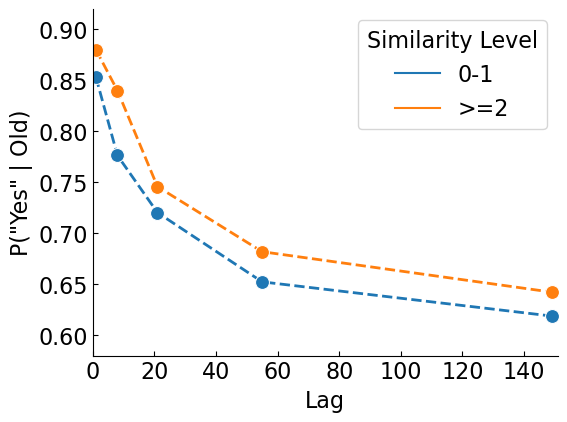

In [14]:
fig, ax = plt.subplots(figsize=(6,4.5))
# fig.subplots_adjust(left=0.1, right=0.98, bottom=0.1, top=0.98)

ax.spines[['right', 'top']].set_visible(False)
ax.tick_params(axis="y",direction="in")
ax.tick_params(axis="x",direction="in")
sns.lineplot(data=df_dprime, y='hr', x='log_lag_disp', hue = 'roll_cat_len_level', marker = 'o', markersize = 10, linestyle='--', lw=2, ax=ax, errorbar=None)
plt.ylabel('P("Yes" | Old)')
plt.xlabel('Lag')
# ax.set(xlabel=None, ylabel=None)
# selected_lag = np.array([1,np.e,np.e**2,np.e**3,np.e**4,np.e**5])
# plt.xticks(ticks=selected_lag, labels = ['1','e','e2','e3','e4','e5'])
plt.xticks(ticks=np.arange(0,160,20))
plt.ylim([0.58,0.92])
plt.xlim([0,151])
# legend_elements = [Line2D([0], [0], color = sns.color_palette()[0], lw=2, marker='o', markersize = 10, linestyle='--',label = 'Low'),
#                    Line2D([0], [0], color = sns.color_palette()[1], lw=2, marker='o', markersize = 10, linestyle='--', label = 'High')]
# plt.legend(handles = legend_elements, title = "Similarity Level")
plt.legend(title = "Similarity Level")

# if SAVEFIG:
#     plt.savefig(f'simu1_fig/simu1_David_hr_{option}.pdf')

findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times Ne

findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times Ne

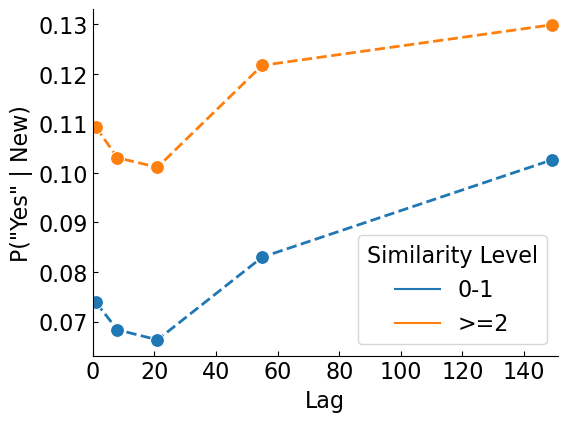

In [15]:
fig, ax = plt.subplots(figsize=(6,4.5))
# fig.subplots_adjust(left=0.1, right=0.98, bottom=0.1, top=0.98)

ax.spines[['right', 'top']].set_visible(False)
ax.tick_params(axis="y",direction="in")
ax.tick_params(axis="x",direction="in")
sns.lineplot(data=df_dprime, y='far', x='log_lag_disp', hue = 'roll_cat_len_level', marker = 'o', markersize = 10, linestyle='--', lw=2, ax=ax, errorbar=None)
plt.ylabel('P("Yes" | New)')
plt.xlabel('Lag')
# ax.set(xlabel=None, ylabel=None)
# selected_lag = np.array([1,np.e,np.e**2,np.e**3,np.e**4,np.e**5])
# plt.xticks(ticks=selected_lag, labels = ['1','e','e2','e3','e4','e5'])
plt.xticks(ticks=np.arange(0,160,20))
# plt.ylim([0.58,0.92])
plt.xlim([0,151])
# legend_elements = [Line2D([0], [0], color = sns.color_palette()[0], lw=2, marker='o', markersize = 10, linestyle='--',label = 'Low'),
#                    Line2D([0], [0], color = sns.color_palette()[1], lw=2, marker='o', markersize = 10, linestyle='--', label = 'High')]
# plt.legend(handles = legend_elements, title = "Similarity Level")
plt.legend(title = "Similarity Level")

# if SAVEFIG:
#     plt.savefig(f'simu1_fig/simu1_David_far_{option}.pdf')

findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times Ne

findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.


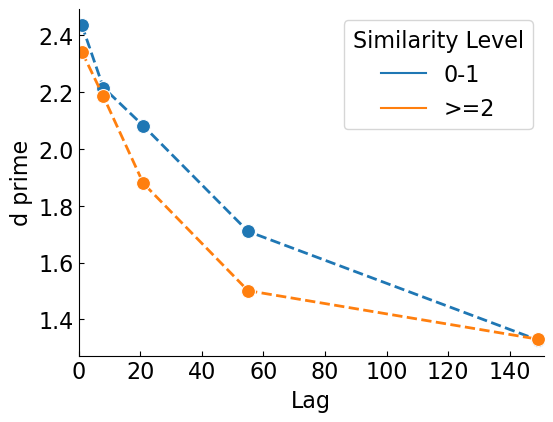

In [16]:
fig, ax = plt.subplots(figsize=(6,4.5))
# fig.subplots_adjust(left=0.1, right=0.98, bottom=0.1, top=0.98)

ax.spines[['right', 'top']].set_visible(False)
ax.tick_params(axis="y",direction="in")
ax.tick_params(axis="x",direction="in")
sns.lineplot(data=df_dprime, y='dprime', x='log_lag_disp', hue = 'roll_cat_len_level', marker = 'o', markersize = 10, linestyle='--', lw=2, ax=ax, errorbar=None)
plt.ylabel('d prime')
plt.xlabel('Lag')
# ax.set(xlabel=None, ylabel=None)
# selected_lag = np.array([1,np.e,np.e**2,np.e**3,np.e**4,np.e**5])
# plt.xticks(ticks=selected_lag, labels = ['1','e','e2','e3','e4','e5'])
plt.xticks(ticks=np.arange(0,160,20))
# plt.ylim([0.58,0.92])
plt.xlim([0,151])
# legend_elements = [Line2D([0], [0], color = sns.color_palette()[0], lw=2, marker='o', markersize = 10, linestyle='--',label = 'Low'),
#                    Line2D([0], [0], color = sns.color_palette()[1], lw=2, marker='o', markersize = 10, linestyle='--', label = 'High')]
# plt.legend(handles = legend_elements, title = "Similarity Level")
plt.legend(title = "Similarity Level")

# if SAVEFIG:
#     plt.savefig(f'simu1_fig/simu1_David_dprime_{option}.pdf')

### Az

In [17]:
def calculate_Az(df_tmp1):
    log_lag_bins = [0, 2, 3, 4, 5]
    Azs = []
    for bin in log_lag_bins:

        # get the df of this log_lag_bin
        col_name = "log_lag_bin_" + str(bin)
        df_tmp = df_tmp1.query(col_name + " == True").copy()

        # get variables
        conf = df_tmp.csim.to_numpy()
        truth = df_tmp.old.to_numpy()
        old_num = np.sum(truth)
        new_num = np.sum(~truth)
        is_old = truth
        is_new = ~truth

        if np.sum(truth) == 0 or np.sum(~truth) == 0:
            Azs.append(np.nan)
            continue
        
        min_conf = np.round(np.min(conf), 2)
        max_conf = np.round(np.max(conf), 2)
        if max_conf - min_conf < 0.1:
            Azs.append(np.nan)
            continue

        # calculate HR and FAR for different thresholds
        step = 0.02
        thresholds = np.arange(min_conf+step, max_conf, step)
        hrs = []
        fars = []
        old_conf = conf * is_old
        new_conf = conf * is_new
        for thresh in thresholds:
            # hr = (np.sum((conf > thresh) & is_old) + 0.5) / (old_num + 1)
            # far = (np.sum((conf > thresh) & is_new) + 0.5) / (new_num + 1)
            hr = (np.sum(old_conf > thresh) + 0.5) / (old_num + 1)
            far = (np.sum(new_conf > thresh) + 0.5) / (new_num + 1)
            hrs.append(hr)
            fars.append(far)

        # calculate z_hr and z_far
        z_hr = norm.ppf(hrs)
        z_far = norm.ppf(fars)

        # # linear regression on z_hr and z_far using sklearn
        # X = np.array(z_far).reshape(-1, 1)
        # y = np.array(z_hr)
        # reg = LinearRegression().fit(X, y)
        # # get slope and intercept 
        # slope = reg.coef_[0]
        # intercept = reg.intercept_

        # linear regression on z_hr and z_far manually
        n = len(z_far)
        X = np.column_stack((np.ones(n), z_far))
        beta = np.linalg.inv(X.T @ X) @ X.T @ z_hr
        intercept, slope = beta

        # get A_z
        Az = norm.cdf(intercept/np.sqrt(1+slope**2))
        Azs.append(Az)

    # df to return
    df_return = pd.DataFrame({'log_lag_bin': log_lag_bins, 'Az': Azs})
    
    return df_return

In [18]:
df_Az = df_simu.groupby(["session", "roll_cat_len_level"]).apply(calculate_Az).reset_index()
df_Az.drop(columns = 'level_2', inplace = True)
df_Az['log_lag_disp'] = np.ceil(np.e**df_Az.log_lag_bin)
df_Az

,session,roll_cat_len_level,log_lag_bin,Az,log_lag_disp
0,0,0-1,0,0.802753,1.0
1,0,0-1,2,0.783792,8.0
2,0,0-1,3,0.791271,21.0
3,0,0-1,4,0.813794,55.0
4,0,0-1,5,0.839493,149.0
...,...,...,...,...,...
4995,499,>=2,0,0.861845,1.0
4996,499,>=2,2,0.819340,8.0
4997,499,>=2,3,0.892022,21.0
4998,499,>=2,4,0.572740,55.0


In [19]:
# pickup those rows where Az is Nan in df_Az
df_Az.loc[df_Az.Az.isna()]

,session,roll_cat_len_level,log_lag_bin,Az,log_lag_disp
19,1,>=2,5,NaN,149.0
24,2,0-1,5,NaN,149.0
29,2,>=2,5,NaN,149.0
34,3,0-1,5,NaN,149.0
38,3,>=2,4,NaN,55.0
...,...,...,...,...,...
4958,495,>=2,4,NaN,55.0
4959,495,>=2,5,NaN,149.0
4979,497,>=2,5,NaN,149.0
4989,498,>=2,5,NaN,149.0


findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times Ne

findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times Ne

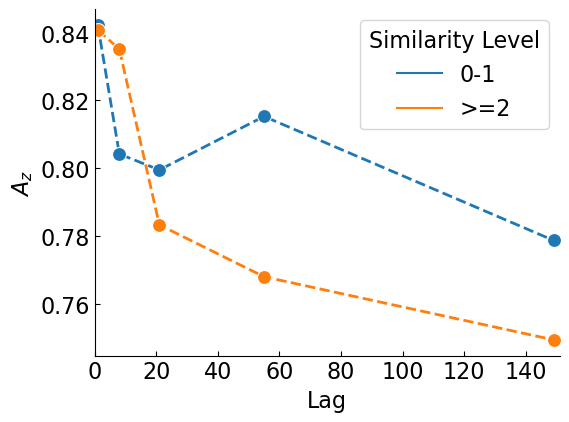

In [20]:
fig, ax = plt.subplots(figsize=(6,4.5))
# fig.subplots_adjust(left=0.1, right=0.98, bottom=0.1, top=0.98)

ax.spines[['right', 'top']].set_visible(False)
ax.tick_params(axis="y",direction="in")
ax.tick_params(axis="x",direction="in")
sns.lineplot(data=df_Az, y='Az', x='log_lag_disp', hue = 'roll_cat_len_level', marker = 'o', markersize = 10, linestyle='--', lw=2, ax=ax, errorbar=None)
plt.ylabel('$A_z$')
plt.xlabel('Lag')
# ax.set(xlabel=None, ylabel=None)
# selected_lag = np.array([1,np.e,np.e**2,np.e**3,np.e**4,np.e**5])
# plt.xticks(ticks=selected_lag, labels = ['1','e','e2','e3','e4','e5'])
plt.xticks(ticks=np.arange(0,160,20))
# plt.ylim([0.58,0.92])
plt.xlim([0,151])
# legend_elements = [Line2D([0], [0], color = sns.color_palette()[0], lw=2, marker='o', markersize = 10, linestyle='--',label = 'Low'),
#                    Line2D([0], [0], color = sns.color_palette()[1], lw=2, marker='o', markersize = 10, linestyle='--', label = 'High')]
# plt.legend(handles = legend_elements, title = "Similarity Level")
plt.legend(title = "Similarity Level")

# if SAVEFIG:
#     plt.savefig(f'simu1_fig/simu1_David_Az_{option}.pdf')

In [21]:
df_plot = df_Az.groupby(["roll_cat_len_level", "log_lag_bin"]).Az.mean().to_frame(name="Az").reset_index()
Az_lowsim = df_plot.query("roll_cat_len_level == '0-1'").Az.to_numpy()
Az_highsim = df_plot.query("roll_cat_len_level == '>=2'").Az.to_numpy()
Az_lowsim, Az_highsim

(array([0.8422902 , 0.80420744, 0.79950844, 0.815288  , 0.7787325 ]),
 array([0.84079123, 0.83511349, 0.78330572, 0.76801249, 0.74940913]))

In [22]:
# ground truth
Az_lowsim_gt = np.array([0.82, 0.82, 0.80, 0.73, 0.63])
Az_highsim_gt = np.array([0.81, 0.78, 0.76, 0.69, 0.61])

# calculate the error
err = np.mean(np.power(Az_lowsim - Az_lowsim_gt, 2)) + np.mean(np.power(Az_highsim - Az_highsim_gt, 2))
err

0.01203830149932393